In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

El siguiente cuaderno busca analizar experimentalmente identificar el posicionamiento óptimo de acuerdo al flujo tal que se obtenga el menor $\Delta\textrm{pH}$ lo cual implicará el menor potencial de caracterización y por lo tanto el menor sesgo.

# Funciones a utilizar

In [2]:
def Lectura(file_dir):
    archivos=os.listdir(file_dir)
    datos={}
    for iArchivo in archivos:
        df=pd.read_excel(os.path.join(file_dir,iArchivo),skiprows=1,header=0,sheet_name="Datos_Crudos")
        datos[iArchivo.replace(".xlsx","")]=(np.abs(df['DELTA pH MRC'][-100:].values).mean(),np.abs(df['DELTA pH MRC'][-100:].values).std()/np.sqrt(len(np.abs(df['DELTA pH MRC'][-100:].values))))
    
    rdatos=dict(datos)
    for iKey in datos.keys():
        if int(iKey.replace("Exp","")) in [0,6,1,10,13,12]:
            del rdatos[iKey]
        else:
            pass
    datos=dict(rdatos)
    return datos

In [3]:
def matrizY(datos):
    Y=[]
    uy=[]
    for i in range(12):
        key="Exp"+str(i)
        if key not in datos.keys():
            pass
        else:
            Y.append(datos[key][0])
            uy.append(np.sqrt(datos[key][1]**2+0.005**2))
    Y=np.array(Y)
    uy=np.array(uy)
    return Y,uy

In [4]:
def matrizX(exp_df):
    X=np.zeros((len(exp_df),10))
    X[:,0]=np.ones_like(X[:,0])
    X[:,1]=exp_df.values[:,0]
    X[:,2]=exp_df.values[:,1]
    X[:,3]=exp_df.values[:,2]
    X[:,4]=exp_df.values[:,1]*exp_df.values[:,0]
    X[:,5]=exp_df.values[:,2]*exp_df.values[:,0]
    X[:,6]=exp_df.values[:,1]*exp_df.values[:,2]
    X[:,7]=exp_df.values[:,0]**2
    X[:,8]=exp_df.values[:,1]**2
    X[:,9]=exp_df.values[:,2]**2
    return X

# Diseño experimental

In [5]:
distancia=[1,2,3] # distancia entre el electrodo y el burbujeador (cm)
profundidad=[5.7,7.7] # profundidad del burbujeador (cm)
flujo=[8.3,66.4] # flujo (SCCM)
experimentos=[(x,y,z) for x in flujo for y in profundidad for z in distancia] # se combinan los factores
exp_df = pd.DataFrame(experimentos,columns=['Flujo (SCCM)','Profundidad (cm)','Distancia (cm)']) # se crea un Datframe del experimento

Como variable respuesta a optimizar se selecciona el $\Delta\textrm{pH}$, que se desea que sea tan cercano a $0$ como sea posible. Mediciones $4$ y $10$, se realizaron en el día $0$, mediciones $3$, $9$, $11$, $5$, $1$ y $7$, se realizaron en el día $1$. Para la construcción del modelo, se realizará un ajuste con Mínimos cuadrados poderados tomando en cuenta la incertidumbre asociada al $\Delta\textrm{pH}$.

In [6]:
exp_df

Flujo (SCCM)  Profundidad (cm)  Distancia (cm)
0            8.3               5.7               1
1            8.3               5.7               2
2            8.3               5.7               3
3            8.3               7.7               1
4            8.3               7.7               2
5            8.3               7.7               3
6           66.4               5.7               1
7           66.4               5.7               2
8           66.4               5.7               3
9           66.4               7.7               1
10          66.4               7.7               2
11          66.4               7.7               3

In [7]:
exp_df=exp_df.drop([i for i in [0,6,1,10]]) # se botaron pruebas que se hicieron en un día distinto y desviaban el ajuste
exp_df

Flujo (SCCM)  Profundidad (cm)  Distancia (cm)
2            8.3               5.7               3
3            8.3               7.7               1
4            8.3               7.7               2
5            8.3               7.7               3
7           66.4               5.7               2
8           66.4               5.7               3
9           66.4               7.7               1
11          66.4               7.7               3

In [8]:
file_dir=r"Datos\Optimización - Celda de pH\Flujos y Distancias\Optimización General"

In [9]:
datos=Lectura(file_dir)

In [10]:
Y,uy=matrizY(datos)

In [11]:
X=matrizX(exp_df)

In [12]:
cov=np.linalg.inv(np.matmul(X.T,X))
b=np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),Y)
y_pred=np.matmul(X,b)
e=Y-y_pred
var=e**2/(len(Y)-1)

In [13]:
w=var+uy**2
W=np.zeros((len(X),len(X)))
for i in range(len(W)):
    W[i,i]=1/w[i]

In [14]:
cov_WLS=np.linalg.inv(np.matmul(np.matmul(X.T,W),X))
b_WLS=np.matmul(np.matmul(np.matmul(cov_WLS,X.T),W),Y)
y_pred=np.matmul(X,b_WLS)
e=Y-y_pred
var=e**2/(len(Y)-1)

In [15]:
np.sqrt(var)

array([0.00391497, 0.00242564, 0.00242564, 0.00242564, 0.00466362,
       0.00466362, 0.00317428, 0.00317428])

In [16]:
b_WLS

array([ 2.40787438e-02, -3.81007675e-03,  6.62334859e-03, -1.88138822e-03,
        1.79583948e-06,  1.12544940e-06, -2.49949588e-05,  5.12595013e-05,
       -6.43892200e-04,  4.67566533e-04])

In [17]:
x_eval=np.linspace(1,3,10)

In [18]:
def X_eval(f,p,d):
    length=10
    mat=np.zeros((length,10))
    mat[:,0]=np.ones(length)
    mat[:,1]=np.ones(length)*f
    mat[:,2]=np.ones(length)*p
    mat[:,3]=np.ones(length)*d
    mat[:,4]=np.ones(length)*f*p
    mat[:,5]=np.ones(length)*f*d
    mat[:,6]=np.ones(length)*p*d
    mat[:,7]=np.ones(length)*f**2
    mat[:,8]=np.ones(length)*p**2
    mat[:,9]=np.ones(length)*d**2
    return mat

In [19]:
F,D=np.meshgrid(np.linspace(8.3,66.4,20),x_eval)

In [20]:
def matZ(F,P,D):
    return b_WLS[0]+b_WLS[1]*F+b_WLS[2]*P+b_WLS[3]*D+b_WLS[4]*F*P+b_WLS[5]*F*D+b_WLS[6]*P*D+b_WLS[7]*F**2+b_WLS[8]*P**2+b_WLS[9]*D**2

In [21]:
Z=matZ(F,5.7,D)

In [22]:
plt.figure(figsize=(15/3,10/3))
plt.contour(F,D,Z,cmap="plasma")
plt.xlabel("Flujo (SCCM)")
plt.ylabel("Distancia (cm)")
plt.title(r"$\Delta$pH para una profundidad de 5.7 cm del burbujeador")
plt.colorbar()
plt.show()

In [23]:
x_Eval=X_eval(12.21,5.7,x_eval)

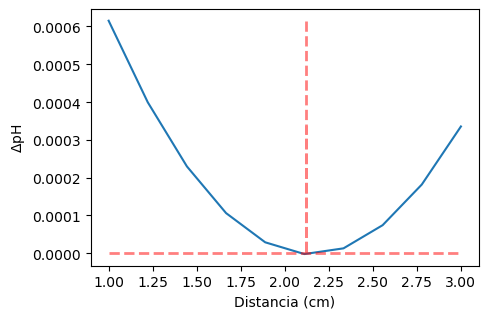

In [24]:
plt.figure(figsize=(15/3,10/3))
plt.plot(x_eval,np.matmul(x_Eval,b_WLS))
plt.plot(np.ones_like(x_eval)*2.12,np.matmul(x_Eval,b_WLS),"r--",linewidth=2,alpha=0.5)
plt.plot(x_eval,np.zeros_like(x_eval),"r--",linewidth=2,alpha=0.5)
plt.xlabel("Distancia (cm)")
plt.ylabel(r"$\Delta$pH")
plt.show()